# Trip_data_reviews Sentiment Analysis

## Problem Statement :
- Building a sentiment analysis model to analyze customer reviews and feedback for a hospitality company
- The model should be able to classify reviews as positive, negative or neutral.

In [1]:
## Importing the required libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import re
import nltk
import emoji
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords,wordnet
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

In [2]:
data = pd.read_csv(r"C:\Users\guruc\Desktop\Trip_data\tripadvisor_hotel_reviews.csv")

## Data Exploration
- Exploring the Sentiment dataset to understand its structure, features, and size.
- Identifying key variables such as tweet content and sentiment labels.

In [3]:
data.head(5)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
data.shape

(20491, 2)

`The above dataset contains two columns:`
- 1.Review : The customer description about the hotel maintenance,stay and other aspects.
- 2.Rating : Rating given to the hotel by the Customer based on their experience or stay in the hotel.

## Exploratory Data Analysis (EDA)

### Creating a copy of the data and working on it so as not to disrupt the original data.

In [5]:
## Create a copy of the data and store in the variable `df`
df = data.copy()

In [6]:
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [7]:
## Check the datatype of the columns in the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [8]:
## Check for any null values or empty records in the data.
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [9]:
## Check for any duplicate entries in the data.
df.duplicated().sum()

0

 `We can see that the dataset does not have any null values and duplicates. If there are any we can use data imputation methods for filling the empty records`

In [10]:
rating_counts = df["Rating"].value_counts()
rating_counts

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

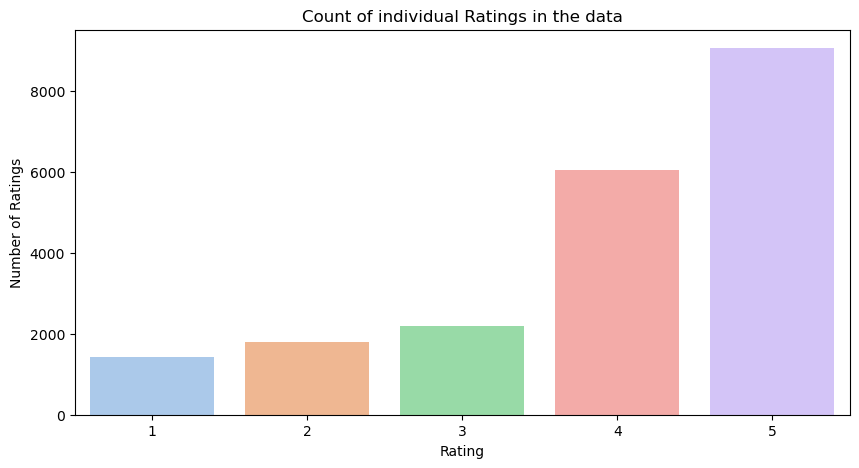

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(x=df["Rating"],palette='pastel')
plt.title("Count of individual Ratings in the data")
plt.ylabel("Number of Ratings")
plt.show()

## Text Preprocessing

### Creating a custom function for checking any unnecessary data and symbols in the data

In [12]:
def check_data(data,name):
    case = " ".join(data[name]).islower()
    html_ = data[name].apply(lambda x:True if re.search("<.+?>",x)else False).sum()
    url_ = data[name].apply(lambda x:True if re.search("http[s]?://.+? +",x) else False).sum()
    unwanted_ = data[name].apply(lambda x:True if re.search("[]()\-.,\?!;@#$%^&*0-9]",x)else False).sum()
    
    emoji_count = 0
    for sen in data:
        for char in sen.split():
            if emoji.is_emoji(char):
                emoji_count += 1
                
    if case == False:
        print(" * Not in lower case")
    else:
        print("In lower case")
    if html_>0:
        print(" * Has html tags")
    else:
        print("No html tags")
    if url_>0:
        print(" * Url's are present")
    else:
        print("No Url's present")
    if unwanted_>0:
        print(" * Unwanted characters are present in the data")
    else:
        print("No Unwanted Characters present")
    if emoji_count>0:
        print(" * Emoji's are Present")
    else:
        print("No Emoji's present")

In [13]:
check_data(df,"Review")

 * Not in lower case
No html tags
No Url's present
 * Unwanted characters are present in the data
No Emoji's present


In [14]:
def lower(data):
    return data.str.lower()

In [15]:
def unwanted_char(data):
    data = data.apply(lambda data : re.sub("[]()\-.,\?!;@#$%^&*0-9]"," ",data))
    return data

In [16]:
def lemmatization(x):
    list_stp = stopwords.words("english")
    wl = WordNetLemmatizer()
    def lemmatize_text(text):
        words = word_tokenize(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]
        return " ".join(lemmatized_words)
    return x.apply(lemmatize_text)

In [17]:
## Creating a pipeline for preprocessing the data in a execution.

In [18]:
processed_pipeline = Pipeline([("Lower",FunctionTransformer(lower)),
                     ("Unwanted_char",FunctionTransformer(unwanted_char)),
                    ("Stop_words",FunctionTransformer(lemmatization))])

In [19]:
df["Review"] = processed_pipeline.fit_transform(df["Review"])

In [20]:
check_data(df,"Review")

In lower case
No html tags
No Url's present
No Unwanted Characters present
No Emoji's present


In [21]:
df.head(5)

,Review,Rating
0,nice hotel expensive park get good deal stay h...,4
1,ok nothing special charge diamond member hilto...,2
2,nice room experience hotel monaco seattle good...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay go seahawk game awesome ...,5


In [22]:
pos_reviews = ' '.join(df[df["Rating"]>=4]["Review"])
neg_reviews = ' '.join(df[df["Rating"]<=2]["Review"])
neu_reviews = ' '.join(df[df["Rating"]==3]["Review"])

In [23]:
lem = WordNetLemmatizer()

In [24]:
pos_rev = lem.lemmatize(pos_reviews)
neg_rev = lem.lemmatize(neg_reviews)
neu_rev = lem.lemmatize(neu_reviews)

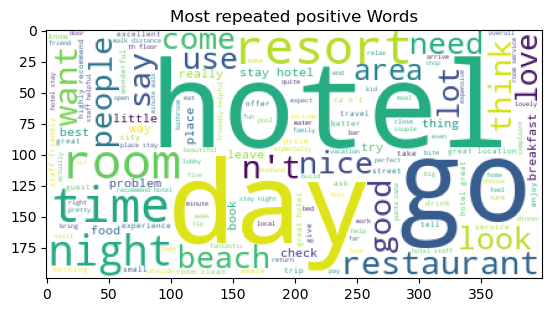

In [25]:
pos_cloud = WordCloud(background_color='White').generate(pos_rev)
plt.imshow(pos_cloud)
plt.title("Most repeated positive Words")
plt.show()

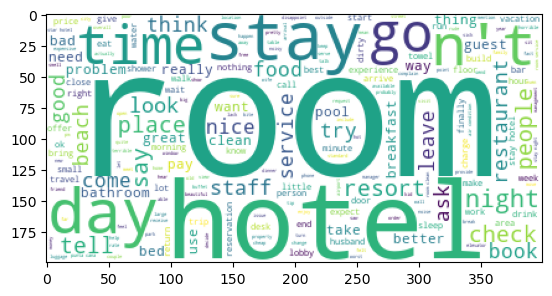

In [26]:
neg_cloud = WordCloud(background_color='White').generate(neg_rev)
plt.imshow(neg_cloud)
plt.show()

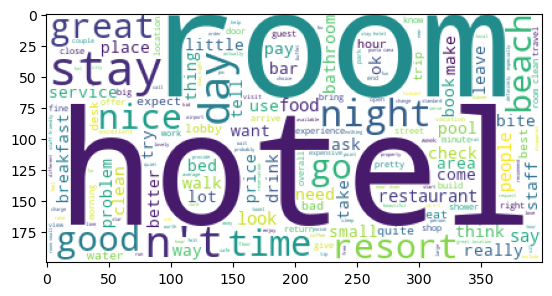

In [27]:
neu_cloud = WordCloud(background_color='White').generate(neu_rev)
plt.imshow(neu_cloud)
plt.show()

In [28]:
df.head(5)

,Review,Rating
0,nice hotel expensive park get good deal stay h...,4
1,ok nothing special charge diamond member hilto...,2
2,nice room experience hotel monaco seattle good...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay go seahawk game awesome ...,5


In [29]:
## Not considering the 5 star Ratings because 4 and 5 together have more values and hence may lead to incline of model towards positive reviews
df = df[df["Rating"]!=5]

In [30]:
df.reset_index(drop=True,inplace=True)
df

,Review,Rating
0,nice hotel expensive park get good deal stay h...,4
1,ok nothing special charge diamond member hilto...,2
2,nice room experience hotel monaco seattle good...,3
3,excellent staff housekeep quality hotel chock ...,4
4,poor value stay monaco seattle july nice hotel...,2
...,...,...
11432,impress unfriendly staff check ask higher floo...,2
11433,great location price view hotel great quick pl...,4
11434,ok look nice modern outside desk staff n't par...,2
11435,hotel theft ruin vacation hotel open sept gues...,1


In [31]:
# Correcting spellings and using vectorized operations
df.loc[df['Rating'] == 4, 'Rating'] = 'Positive'
df.loc[df['Rating'] == 3, 'Rating'] = 'Neutral'
df.loc[df['Rating'] == 2, 'Rating'] = 'Negative'
df.loc[df['Rating'] == 1, 'Rating'] = 'Negative'

C:\Users\guruc\AppData\Local\Temp\ipykernel_15992\983616424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['Rating'] == 4, 'Rating'] = 'Positive'


In [32]:
df["Rating"].value_counts()

Positive    6039
Negative    3214
Neutral     2184
Name: Rating, dtype: int64

In [33]:
## Dividing the data into feature variable(fv) and class variable(cv)
fv = df["Review"]
cv = df["Rating"]

In [34]:
## Splitting the data into training and test data.
x_train,x_test,y_train,y_test = train_test_split(fv,cv,test_size=0.2,random_state=30,stratify=cv)

In [35]:
## Splitting the train data again for cross validation.
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=30,stratify=y_train)

In [36]:
## Extracting the length of each Review for Vochabulary building.
sent_len = []
for sent in df['Review']:
    sent_len.append(len(word_tokenize(sent)))
df['Sent_length'] = sent_len
df.head()

C:\Users\guruc\AppData\Local\Temp\ipykernel_15992\1410946655.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sent_length'] = sent_len


,Review,Rating,Sent_length
0,nice hotel expensive park get good deal stay h...,Positive,81
1,ok nothing special charge diamond member hilto...,Negative,233
2,nice room experience hotel monaco seattle good...,Neutral,203
3,excellent staff housekeep quality hotel chock ...,Positive,86
4,poor value stay monaco seattle july nice hotel...,Negative,45


In [37]:
from sklearn.preprocessing import LabelEncoder

In [38]:
lb = LabelEncoder()
final_y_train=lb.fit_transform(y_train)

In [39]:
final_y_cv = lb.transform(y_cv)

In [40]:
max(df["Sent_length"])

1890

In [41]:
min(df["Sent_length"])

8

In [42]:
# Check the most common length of review
np.quantile(df['Sent_length'],0.95)

283.1999999999989

In [43]:
# Changing the maximum length of a sentence to 260 as 95% of the reviews are in 260 words.
max_length = 283

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [45]:
## Performing word tokenization
tk = Tokenizer()
tk.fit_on_texts(x_train)

In [46]:
vocab_len = len(tk.index_word)
vocab_len

26000

In [47]:
## Converting the text into sequences
seq_x_train = tk.texts_to_sequences(x_train)

In [48]:
seq_x_cv = tk.texts_to_sequences(x_cv)

In [49]:
from keras.utils import pad_sequences

In [50]:
## Padding the sequence data to make the dimensionality same for all the data points.
final_x_train = pad_sequences(seq_x_train,maxlen=max_length)
final_x_train

array([[   0,    0,    0, ..., 2019,  731,  590],
       [   0,    0,    0, ...,  222,  451,    1],
       [   0,    0,    0, ..., 1107,    1, 9933],
       ...,
       [   0,    0,    0, ...,  503,  448,    2],
       [   0,    0,    0, ...,   73,    5,   13],
       [   0,    0,    0, ..., 1521,  455,    2]])

In [51]:
final_x_cv = pad_sequences(seq_x_cv,maxlen=max_length)
final_x_cv

array([[   0,    0,    0, ...,  503,    6,  384],
       [   0,    0,    0, ...,  983, 4891, 3021],
       [   0,    0,    0, ...,    2,   42, 1209],
       ...,
       [   0,    0,    0, ...,   14,   49, 6691],
       [   0,    0,    0, ...,  100,   82,    2],
       [   0,    0,    0, ..., 1066,  390, 1768]])

In [52]:
final_x_train.shape

(7319, 283)

In [53]:
from keras.models import Sequential
from keras.layers import Dense,Input,InputLayer,LSTM,GRU,SimpleRNN,Embedding

In [54]:
y_train.value_counts()

Positive    3865
Negative    2057
Neutral     1397
Name: Rating, dtype: int64

# Model Building for Sentiment Analysis

In [55]:
# Using an LSTM structure for the model.
model = Sequential()
model.add(InputLayer((283,)))
model.add(Embedding(26001,200))
model.add(LSTM(100,activation='tanh'))
model.add(Dense(10,activation='relu'))
model.add(Dense(3,activation='softmax'))

In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 283, 200)            │       5,200,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,321,643 (20.30 MB)

 Trainable params: 5,321,643 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [58]:
model.fit(final_x_train,final_y_train,batch_size=100,epochs=10,validation_data=(final_x_cv,final_y_cv))

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 328ms/step - accuracy: 0.5308 - loss: 0.9925 - val_accuracy: 0.6880 - val_loss: 0.7720
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 290ms/step - accuracy: 0.7354 - loss: 0.6499 - val_accuracy: 0.7197 - val_loss: 0.6991
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - accuracy: 0.7910 - loss: 0.5062 - val_accuracy: 0.7284 - val_loss: 0.7009
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 24s 321ms/step - accuracy: 0.8970 - loss: 0.2889 - val_accuracy: 0.6820 - val_loss: 0.8031
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 316ms/step - accuracy: 0.9443 - loss: 0.1796 - val_accuracy: 0.7131 - val_loss: 1.0928
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.9591 - loss: 0.1354 - val_accuracy: 0.6831 - val_loss: 1.0388
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 24s 322ms/step - accuracy: 0.9742 - loss: 0.0896 - val_accuracy: 0.6918 - val_loss: 1.1414
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 24s 319ms/step - accuracy: 0.9796 - loss: 0.0631 - val_accu

In [59]:
final_x_test = pad_sequences(tk.texts_to_sequences(x_test),maxlen=max_length)

In [60]:
final_y_test = lb.transform(y_test)

In [61]:
y_pred = model.predict(final_x_test)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


In [62]:
final_x_test.shape

(2288, 283)

In [63]:
y_pred.shape

(2288, 3)

In [80]:
final_y_train

array([0, 1, 0, ..., 0, 2, 1])

In [81]:
y_train

10897    Negative
2895      Neutral
6918     Negative
2376     Positive
9614      Neutral
           ...   
3957     Positive
7287     Negative
9981     Negative
5905     Positive
9792      Neutral
Name: Rating, Length: 7319, dtype: object

In [64]:
np.argmax(y_pred,axis=1)

array([1, 1, 2, ..., 2, 2, 0], dtype=int64)

In [65]:
from sklearn.metrics import accuracy_score

In [66]:
accuracy_score(final_y_test,np.argmax(y_pred,axis=1))

0.6700174825174825

## Machine Learning Models

In [67]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [68]:
## Splitting the data into training and test data.
x_train,x_test,y_train,y_test = train_test_split(fv,cv,test_size=0.2,random_state=30,stratify=cv)

In [69]:
## Splitting the train data again for cross validation.
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=30,stratify=y_train)

In [70]:
cv1 = CountVectorizer(binary=True)

In [71]:
# transforming the data used for model prediction into a sparse matrix
train = cv1.fit_transform(x_train)

In [72]:
train

<7319x26346 sparse matrix of type '<class 'numpy.int64'>'
	with 587190 stored elements in Compressed Sparse Row format>

In [73]:
cv1.transform(x_test)

<2288x26346 sparse matrix of type '<class 'numpy.int64'>'
	with 181576 stored elements in Compressed Sparse Row format>

In [74]:
from sklearn.naive_bayes import BernoulliNB,MultinomialNB,CategoricalNB

# Bernoulli's Naive Bayes

In [75]:
b =BernoulliNB(alpha = 0.1)
final_model=b.fit(train,y_train)
final_model.predict(cv1.transform(x_test))
accuracy_score((y_test),final_model.predict(cv1.transform(x_test)))

0.6958041958041958

# Multinomial Naive Bayes

In [76]:
mn =MultinomialNB(alpha = 0.1)
final_model1=mn.fit(train,y_train)
final_model1.predict(cv1.transform(x_test))
accuracy_score((y_test),final_model.predict(cv1.transform(x_test)))

0.6958041958041958

# Classification Report

In [77]:
print(classification_report(y_test,final_model.predict(cv1.transform(x_test))))

              precision    recall  f1-score   support

    Negative       0.76      0.72      0.74       643
     Neutral       0.33      0.22      0.27       437
    Positive       0.74      0.85      0.80      1208

    accuracy                           0.70      2288
   macro avg       0.61      0.60      0.60      2288
weighted avg       0.67      0.70      0.68      2288



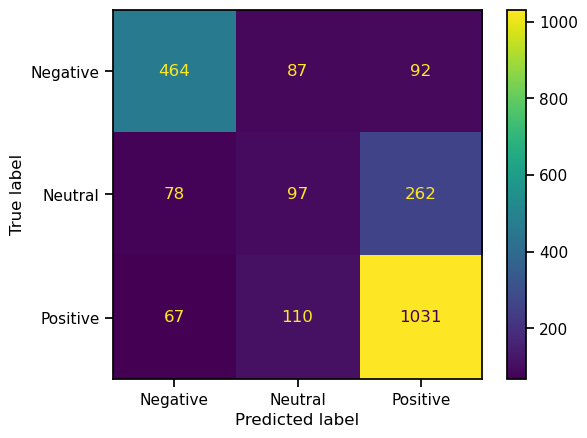

In [78]:
sns.set_theme(style=None)
cm = confusion_matrix(y_test,final_model.predict(cv1.transform(x_test)))
i = ConfusionMatrixDisplay(cm,display_labels=b.classes_)
i.plot()
plt.show()

In [ ]:
import pickle

In [ ]:
pickle.dump(processed_pipeline,open(r"C:\Users\guruc\Desktop\charan\Streamlit\final_pipe.pkl","wb"))

In [ ]:
pickle.dump(final_model,open(r"C:\Users\guruc\Desktop\charan\Streamlit\final_sent_model","wb"))